In [ ]:
# Aalto Matrix Compeltion  
## recommendation problem for Music (an in class Kaggle challenge)
#### https://inclass.kaggle.com/c/aalto-music-listening-prediction
### Realised by :  Sakly Sami ,Roodnejad Maxime  
### Master Class AIC - UPSay                

Original data were in the form of matlab (.mat) files. So we had convert them to csv.

In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys

In [2]:
# the first issue after converting the data to csv is that the value we are going to predict 
# are left empty (not a nan) , so we replace them do a count to check with competition information 
# and also keep position i and j position in the matrix in two separate  
def transform_empty_toNumpyNan(filename):
    """
    input  : raw csv matrix
    output : matrix with empty replaced by nans
             nan_elements_number as the total_number of nan
             ipos_rawdata and jpos_rawdata containing couple of the i and the j of each nan position
             
    """
    with open(filename, 'rb') as f:
        reader = csv.reader(f)
        raw_data = list(reader)
        total_zeros = 0
        nan_elements_number = 0
        ipos_rawdata = []
        jpos_rawdata = []
        non_nul_per_user_array = np.zeros(len(raw_data))
        for j in range(len(raw_data[0])):
                #row/user
            for i in range(len(raw_data)):

                if(raw_data[i][j])=="":

                    nan_elements_number +=1
                    ipos_rawdata.append(i)
                    jpos_rawdata.append(j)
                    raw_data[i][j] = np.nan
                else:
                    raw_data[i][j]=int(raw_data[i][j])
                    if raw_data[i][j] > 0.0 :
                        non_nul_per_user_array[i]+=1
                
    return raw_data,nan_elements_number,ipos_rawdata,jpos_rawdata,non_nul_per_user_array

raw_data_transformed, nan_elements_number,ipos_rawdata,jpos_rawdata,non_nul_per_user_array = transform_empty_toNumpyNan('user_artist_matrix_with_nans.csv')

In [3]:
user_number = np.shape(raw_data_transformed)[0]
item_number = np.shape(raw_data_transformed)[1]
print "number of user X number of artists : ", np.shape(raw_data_transformed)

number of user X number of artists :  (1372, 4322)


In [4]:
total_number_of_elemnt = (user_number * item_number) *1.0
print "nan number : ", nan_elements_number
print "nan ratio : ", nan_elements_number/total_number_of_elemnt
print "sparcity ratio :", (total_number_of_elemnt - np.count_nonzero(raw_data_transformed))/total_number_of_elemnt
print "average non null values per user :", int( np.mean(non_nul_per_user_array))

nan number :  35021
nan ratio :  0.00590594868211
sparcity ratio : 0.96220132133
average non null values per user : 137


In [5]:
# list of nans of every user i
# for plotting
unique_nans =[]
for i in np.unique(ipos_rawdata):
    unique_nan_i = []
    for t in range(len(ipos_rawdata)):
        if ipos_rawdata[t] == i :
            unique_nan_i.append(jpos_rawdata[t])
    unique_nans.append(unique_nan_i)

In [6]:
print unique_nans[0]

[82, 95, 152, 330, 531, 549, 567, 765, 812, 886, 934, 994, 1023, 1072, 1149, 1249, 1348, 1393, 1472, 1491, 1708, 1760, 1840, 1883, 1885, 1951, 1972, 1991, 2049, 2091, 2096, 2111, 2123, 2185, 2242, 2337, 2437, 2439, 2500, 2558, 2609, 2627, 2657, 2705, 2724, 2799, 2821, 2848, 2868, 2889, 2943, 2996, 3034, 3223, 3381, 3411, 3470, 3473, 3500, 3511, 3583, 3669, 3687, 3734, 3788, 3804, 3823, 3887, 3970, 4002, 4059, 4077, 4231, 4256]


In [7]:
def count_user_total_play(matrix):
    """
    input  : user-item matrix
    output : a list of couple (total_songs_user0, total_songs_user1, ..)
    """
    user_artist_total = []
    for i in range(0,np.shape(matrix)[0]):
        user_artist_total.append(np.nansum(np.array(matrix[i])))
    return user_artist_total
        

In [8]:
total_count_user_item = count_user_total_play(raw_data_transformed)

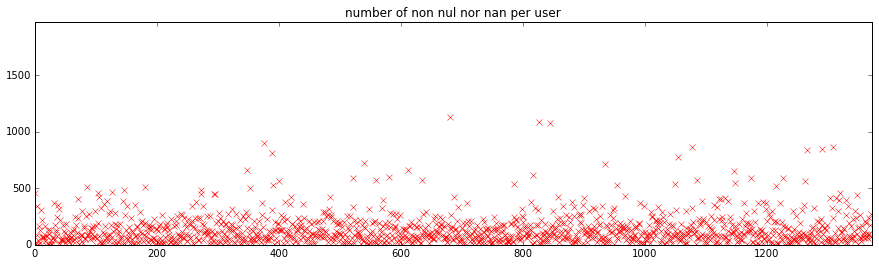

In [9]:

plt.rcParams["figure.figsize"] = (15,4)
plt.plot(np.arange(0,len(non_nul_per_user_array)), non_nul_per_user_array,'rx')
plt.axis([0, len(total_count_user_item), 0, np.max(total_count_user_item)/3])
plt.title('number of non nul nor nan per user')
plt.figure(figsize=(40,10))

In [10]:
# the mean number of unique songs listened by one user is nearly 795, which is low compared and prove 
# the difficulty of the difficulty of the task
np.mean(total_count_user_item)

794.24052478134115

In [11]:
# the maximum number of unique songs listened by one user is 5927
np.max(total_count_user_item)

5927.0

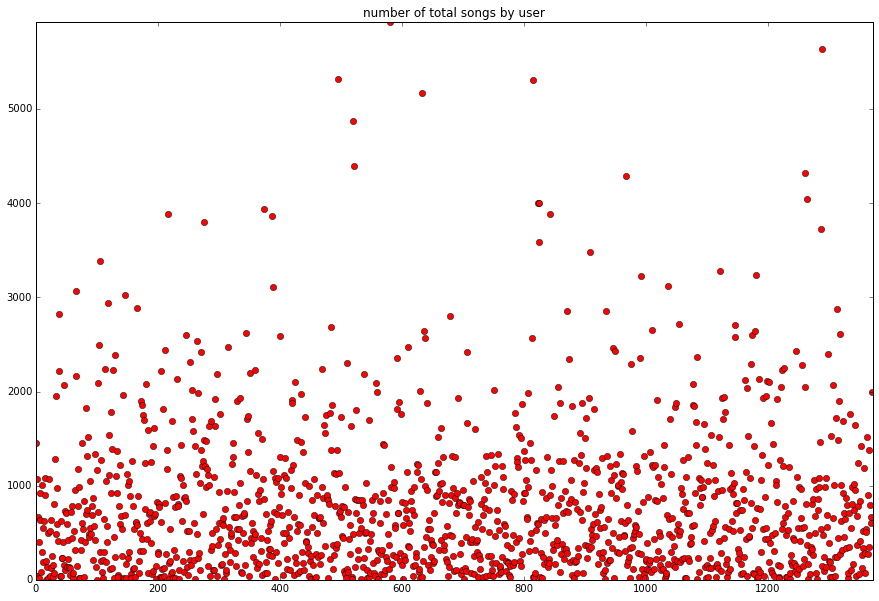

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(np.arange(0,len(total_count_user_item)), total_count_user_item ,'ro')
plt.axis([0, len(total_count_user_item), 0, np.max(total_count_user_item)])
plt.title("number of total songs by user ")
plt.figure(figsize=(40,10))

In [ ]:
# This was the simplest way to impute the nan value using SKlearn
# gave no real result

#from sklearn.preprocessing import Imputer
#imp = Imputer(strategy="mean")
#aa = imp.fit_transform(raw_data_transformed)
#score_to_write1 = []
#for i in range(len(ipos_rawdata)):
#    posi = ipos_rawdata[i]
#    posj = jpos_rawdata[j]
#    if aa[posi][posj] >=1.0 :
#        aa[posi][posj] == 1.0
#        score_to_write1.append(1)
#    else :
#        score_to_write1.append(0)
        
# Nope fail 0.4 :x

## Implicit feed Back Matrix Factorization 

In [14]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import time


class ImplicitMF():

    def __init__(self, counts, num_factors=40, num_iterations=30,
                 reg_param=0.8):
        self.counts = counts
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def train_model(self):
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))

        for i in xrange(self.num_iterations):
            t0 = time.time()
            print 'Solving for user vectors...'
            self.user_vectors = self.iteration(True, sparse.csr_matrix(self.item_vectors))
            print 'Solving for item vectors...'
            self.item_vectors = self.iteration(False, sparse.csr_matrix(self.user_vectors))
            t1 = time.time()
            print 'iteration %i finished in %f seconds' % (i + 1, t1 - t0)

    def iteration(self, user, fixed_vecs):
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        YTY = fixed_vecs.T.dot(fixed_vecs)
        eye = sparse.eye(num_fixed)
        lambda_eye = self.reg_param * sparse.eye(self.num_factors)
        solve_vecs = np.zeros((num_solve, self.num_factors))

        t = time.time()
        for i in xrange(num_solve):
            if user:
                counts_i = self.counts[i].toarray()
            else:
                counts_i = self.counts[:, i].T.toarray()
            CuI = sparse.diags(counts_i, [0])
            pu = counts_i.copy()
            pu[np.where(pu != 0)] = 1.0
            YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
            YTCupu = fixed_vecs.T.dot(CuI + eye).dot(sparse.csr_matrix(pu).T)
            xu = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)
            solve_vecs[i] = xu
            if i % 1000 == 0:
                print 'Solved %i vecs in %d seconds' % (i, time.time() - t)
                t = time.time()

        return solve_vecs

In [15]:
import scipy.sparse as sparse

def load_matrix2(raw_data_transformed):
    where_nan = np.isnan(raw_data_transformed)
    raw_data_no_nans = np.copy(raw_data_transformed)
    raw_data_no_nans[where_nan]= 0
    total_number_of_elemnt = (np.shape(raw_data_no_nans)[0] * np.shape(raw_data_no_nans)[1]) *1.0
    print total_number_of_elemnt
    alpha = (total_number_of_elemnt - np.count_nonzero(raw_data_no_nans)) / np.sum(raw_data_no_nans) 
    print alpha
    counts = np.copy(raw_data_no_nans)
    print 'alpha %.2f' % alpha
    counts *= alpha
    counts = sparse.csr_matrix(counts)
    return counts

counts_MF = load_matrix2(raw_data_transformed)

5929784.0
5.26812658186
alpha 5.27


In [16]:
# reg param = 0.8
# 40 factors and 30 iterations obtained 0.852 at best with threshold = 0.2
# 40 factors and 80 iterations obtained 
# 10 factors and 50 iterations obtained 0.849 at best with threshold = 0.21
# 30 factors and 50 iterations obtained 0.85935 at best with threshold = 0.22
# 30 factors and 100 iterations obtained 0.85935 at best with threshold = 0.22
#reg param 0.5 
# 30 factors and 50 iterations obtained 0.85529 at best with threshold = 0.16
#reg param 0.9
# 50 factors and 60 iterations obtained 0.84

# change here for different parameter
implicit_factor_instance = ImplicitMF(counts_MF,num_factors=30, num_iterations=100,
                 reg_param=0.8)

In [ ]:
implicit_factor_instance.train_model()

In [115]:
# reconstruction of the matrix
solved_mat = np.dot(implicit_factor_instance.user_vectors,implicit_factor_instance.item_vectors.T)

In [17]:
# rating list contains 5615 neg element, I will first try to put negative value to 0 and others to 1 
def generate_rating_list(solved_mat,ipos,jpos,threshold):
    res_rating_list = []
    factored_rating_list=[]
    for i in range(len(ipos)):
        item_id = jpos[i]
        user_id = ipos[i]
        factored_rating_list.append(solved_mat[user_id][item_id])
        if solved_mat[user_id][item_id]<= threshold :
            res_rating_list.append(0)
        else:
            res_rating_list.append(1)
    return factored_rating_list, res_rating_list

In [18]:
def generate_id_submission(ipos,jpos):
    """
    We can still use the id from the submission file, but using the one we generate we are pretty
    sure we are submitting the correct ones or the submission system will reject it 
    """
    id_prediction = []
    #user
    for i in range(len(ipos)):
        #item
        id_prediction.append((ipos[i] + 1) + jpos[i] * 1372)
    return id_prediction

In [19]:
def generate_submission(filename,rating_list,id_prediction):
    with open(filename, 'rb') as f:
        reader = csv.reader(f)
        raw_submission_data = list(reader)
    with open(filename, 'wb') as h:
        s = "Id"
        b= "Prediction"
        writer = csv.writer(h)
        writer.writerow((s,b))
        for i in range(len(id_prediction)):
            writer.writerow((id_prediction[i],int(rating_list[i])))
    print len(raw_submission_data) 
    print "file generated succesfully, Good Luck Bro !"

In [ ]:
id_prediction = generate_id_submission(ipos_rawdata,jpos_rawdata)

In [136]:
factore_rating_list,scaled_rating_list = generate_rating_list(solved_mat,ipos_rawdata,jpos_rawdata,0.225)
print "max :", np.max(factore_rating_list)
print 'min :', np.min(factore_rating_list)
print 'mean :',np.mean(factore_rating_list)

max : 1.62647929442
min : -0.727725458125
mean : 0.426616597282


In [137]:
generate_submission('sampleSubmission.csv',scaled_rating_list,id_prediction)

35022
file generated succesfully, Good Luck Bro !
